### Advanced Lane Finding

In [82]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
import os
import glob
from os import listdir
from os.path import isfile, join
%matplotlib inline


#### Camera Calibration. 
Use /camera_cal to adjust for distortion. Orig on left, corrected on right. 
Step one: Plot cornders and correct to 9.6 as per instructions. Quality control by visual inspection

processing: camera_cal/calibration1.jpg
processing: camera_cal/calibration10.jpg
processing: camera_cal/calibration11.jpg
processing: camera_cal/calibration12.jpg
processing: camera_cal/calibration13.jpg
processing: camera_cal/calibration14.jpg
processing: camera_cal/calibration15.jpg
processing: camera_cal/calibration16.jpg
processing: camera_cal/calibration17.jpg
processing: camera_cal/calibration18.jpg
processing: camera_cal/calibration19.jpg
processing: camera_cal/calibration2.jpg
processing: camera_cal/calibration20.jpg
processing: camera_cal/calibration3.jpg
processing: camera_cal/calibration4.jpg
processing: camera_cal/calibration5.jpg
processing: camera_cal/calibration6.jpg
processing: camera_cal/calibration7.jpg
processing: camera_cal/calibration8.jpg
processing: camera_cal/calibration9.jpg


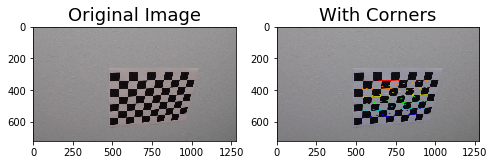

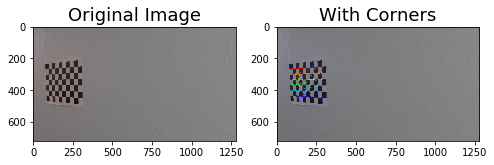

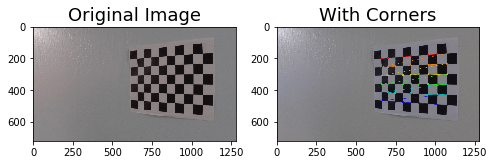

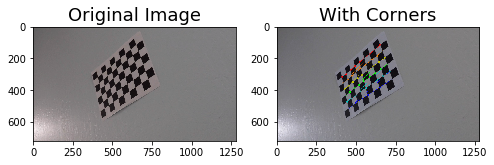

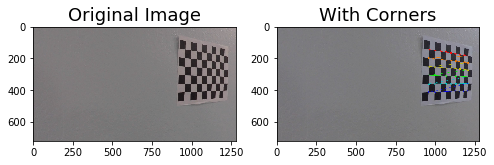

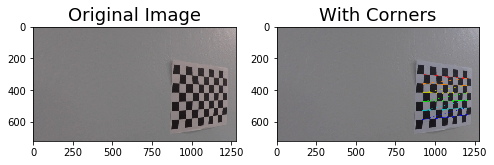

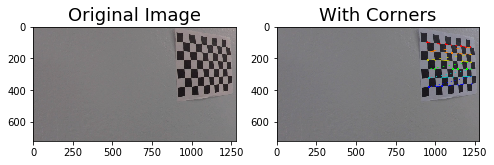

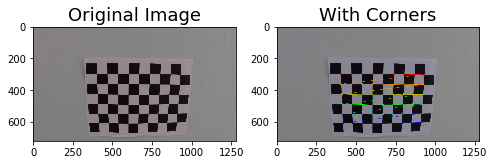

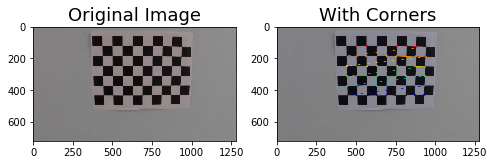

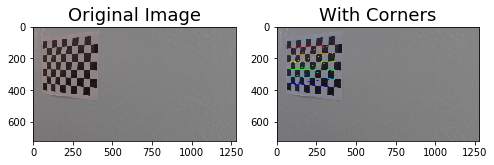

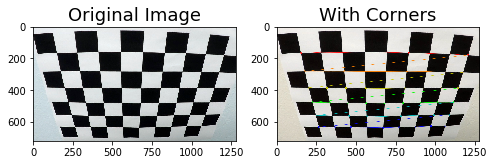

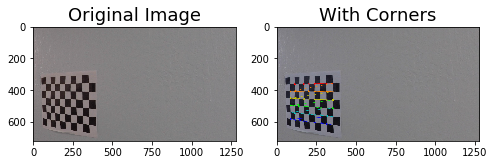

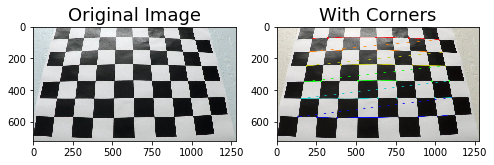

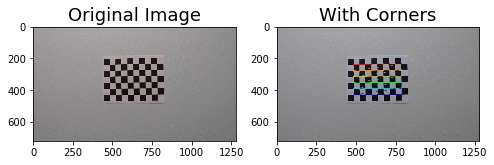

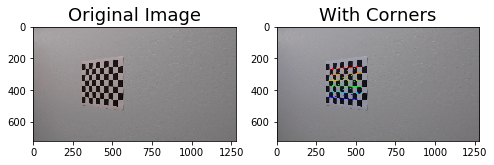

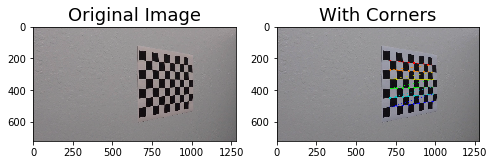

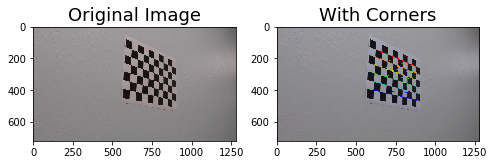

In [83]:
#Step 1: verify corners are well behaved

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')

for idx, fname in enumerate(images):
    print ('processing:', fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)


In [84]:
# Remove distortion from images
def undistort(image, show=True, read = True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=18)
    else:
        return undist

processing: test_images/straight_lines1.jpg
processing: test_images/straight_lines2.jpg
processing: test_images/test1.jpg
processing: test_images/test2.jpg
processing: test_images/test3.jpg
processing: test_images/test4.jpg
processing: test_images/test5.jpg
processing: test_images/test6.jpg


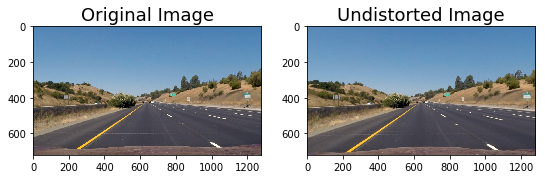

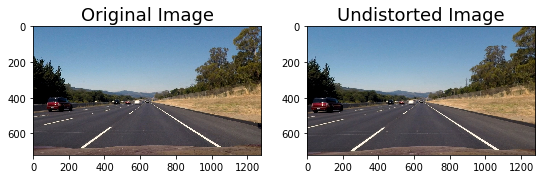

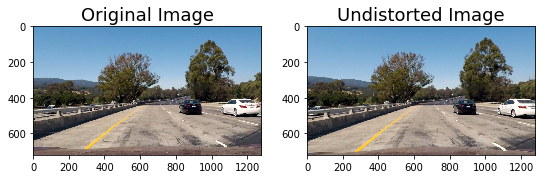

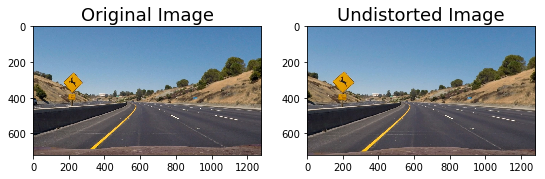

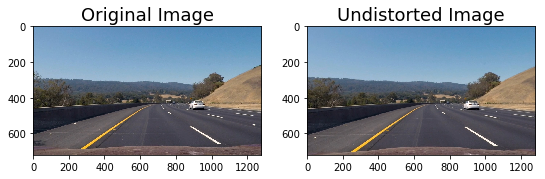

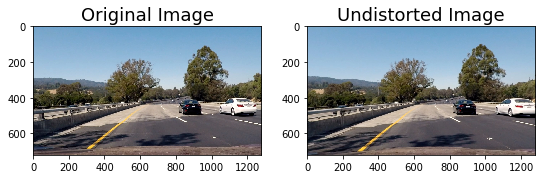

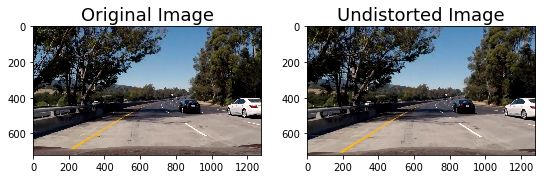

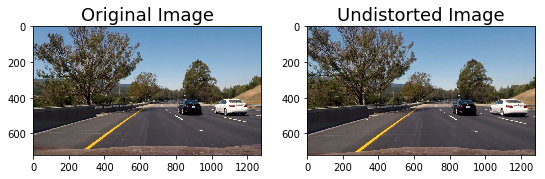

In [85]:
images = glob.glob('test_images/*.jpg')
for image in images:
    print ('processing:', image)
    undistort(image)


In [96]:
# Perform perspective transform


class Constant:
    def __init__(self):
        self.TOP_LEFT=[490,480]
        self.TOP_RIGHT=[810,480]
        self.BOTTOM_RIGHT=[1250,700]
        self.BOTTOM_LEFT=[40,720]
        self.src = np.float32([TOP_LEFT,TOP_RIGHT,BOTTOM_RIGHT,BOTTOM_LEFT])
        self.dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])

        
def birds_eye(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    
    const = Constant()

    img_size = (undist.shape[1], undist.shape[0])
    #print (undist.shape)
    src = np.float32([const.TOP_LEFT,const.TOP_RIGHT,const.BOTTOM_RIGHT,const.BOTTOM_LEFT])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        cv2.line(undist,(490,480),(810,480),(255,0,0),3)
        cv2.line(undist,(1250,720),(810,480),(255,0,0),3)
        cv2.line(undist,(40,720),(1250,720),(255,0,0),3)
        cv2.line(undist,(490,480),(40,720),(255,0,0),3)
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


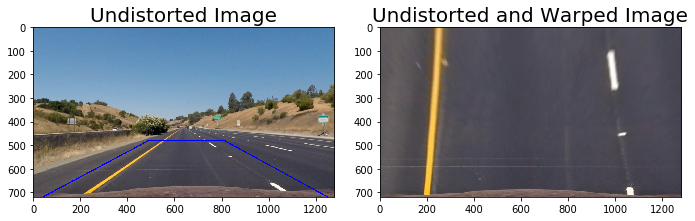

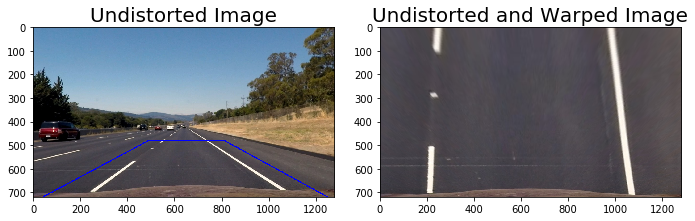

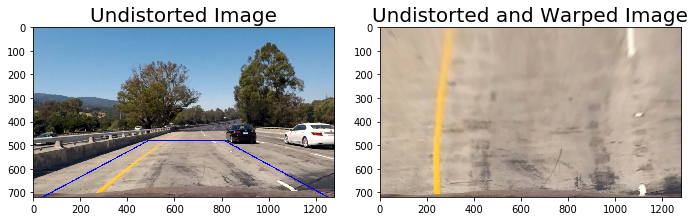

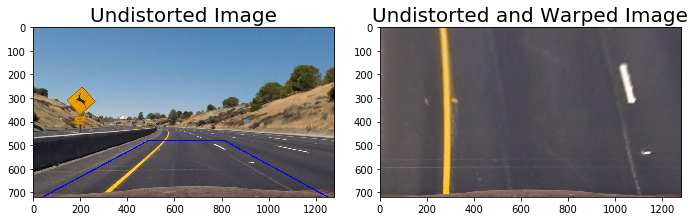

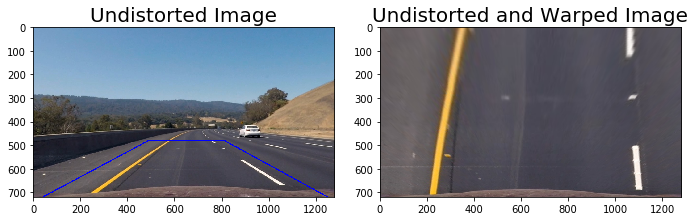

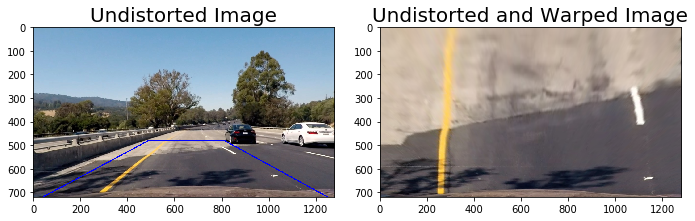

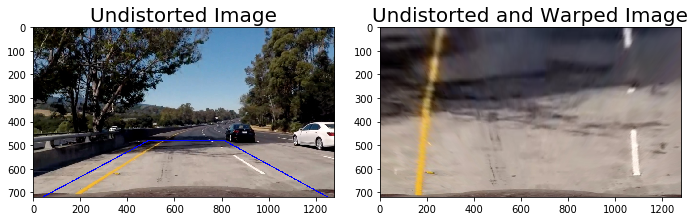

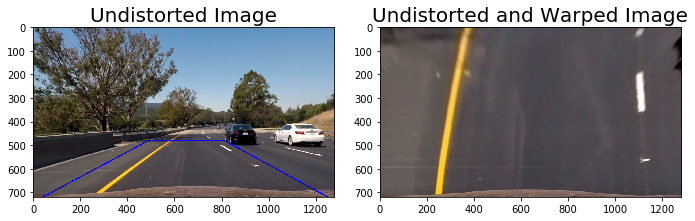

In [97]:
for image in glob.glob('test_images/*.jpg'):
    print (image)
    birds_eye(image)


In [89]:
# Create binary thresholded images to isolate lane line pixels

def apply_thresholds(image, show=True):
    img, M = birds_eye(image, display = False)
    
    HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)    
    #h_channel = HLS[:,:,0]
    #l_channel = HLS[:,:,1]
    s_channel = HLS[:,:,2]
    
    
    LUV = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    l_channel = LUV[:,:,0]
    u_channel = LUV[:,:,1]
    v_channel = LUV[:,:,2]
    
    #Is there a difference between full color range in LAB vs. RGB?
    BGR2 = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    r_channel = BGR2[:,:,2]   
    #g2_channel = BGR[:,:,]
    #r2_channel = BGR[:,:,]
    
    
    # Threshold color channel
    s_thresh_min = 170 
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    r_thresh_min = 150
    r_thresh_max = 200
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    
    l_thresh_min = 220
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (r_binary == 1)] = 1

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('r binary threshold', fontsize=16)
        ax4.imshow(r_binary, cmap='gray')
        
        ax5.set_title('l binary threshold', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('s+l+r thresholds', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


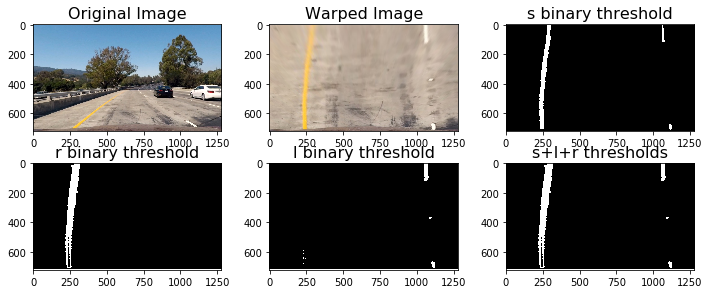

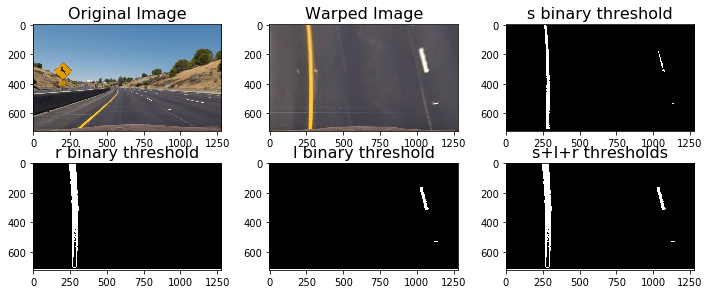

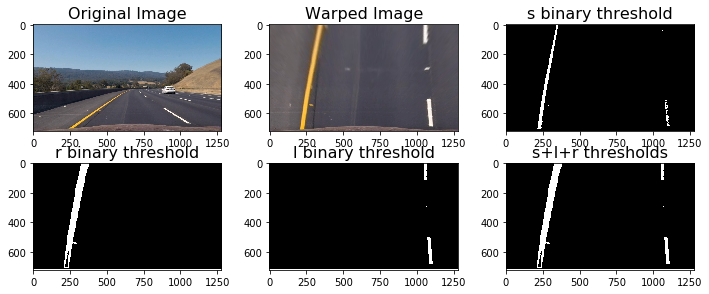

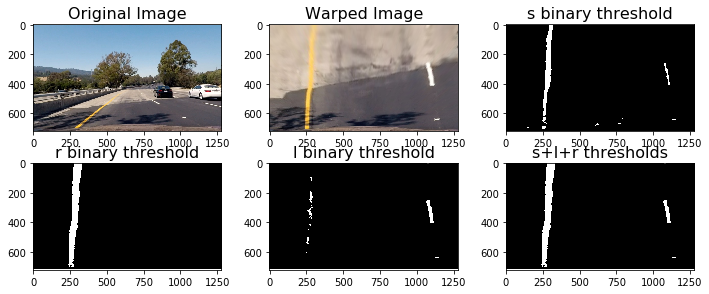

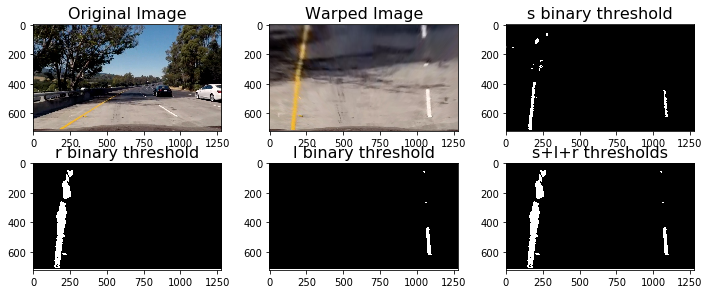

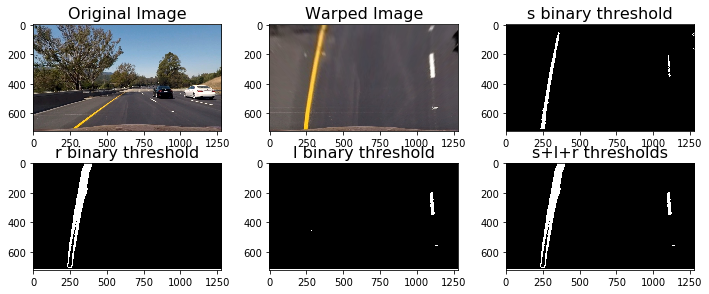

In [90]:
for image in glob.glob('test_images/test*.jpg'):
    apply_thresholds(image,show=True)


In [91]:
def find_lecture(binary_warped):
    #print ('binary_warped shape:', binary_warped.shape)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    #print('window_height:',window_height)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        #print ('window:',window)
        #print('leftx_current:',leftx_current, 'rightx_current',rightx_current)
        #print('win_y_low',win_y_low,' win_y_high',win_y_high)
        #print('win_xleft_low',win_xleft_low,' win_xleft_high',win_xleft_high)
        #print('win_xright_low',win_xright_low,' win_xright_high',win_xright_high)
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return lefty, leftx, righty, rightx

In [80]:
def fill_lane(image):
    
    combined_binary = apply_thresholds(image, show=False)
    
    lefty, leftx, righty, rightx = find_lecture(combined_binary)
    
    
    #poly fit
    left_fit = np.polyfit(lefty, leftx, 2)
    #make lane lines from polyfit
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    #fill in the pixels for the curves. 
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 480],[810, 480],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((birds_eye(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='green', linewidth=3)
    ax1.plot(right_fitx, righty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    ax2.text(200, 175, 'curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=10)

(720, 1280, 3)
binary_warped shape: (720, 1280)
window_height: 80
(720, 1280, 3)
(720, 1280, 3)
binary_warped shape: (720, 1280)
window_height: 80
(720, 1280, 3)
(720, 1280, 3)
binary_warped shape: (720, 1280)
window_height: 80
(720, 1280, 3)
(720, 1280, 3)
binary_warped shape: (720, 1280)
window_height: 80
(720, 1280, 3)
(720, 1280, 3)
binary_warped shape: (720, 1280)
window_height: 80
(720, 1280, 3)
(720, 1280, 3)
binary_warped shape: (720, 1280)
window_height: 80
(720, 1280, 3)


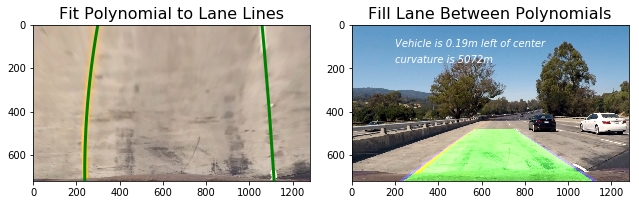

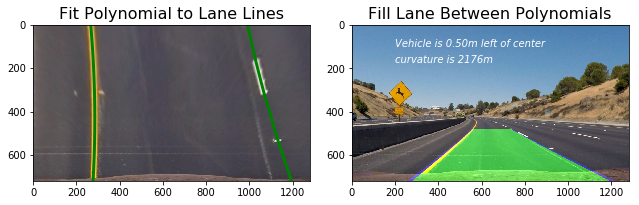

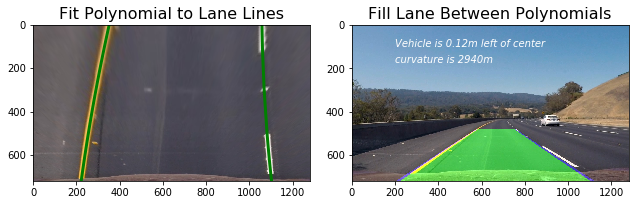

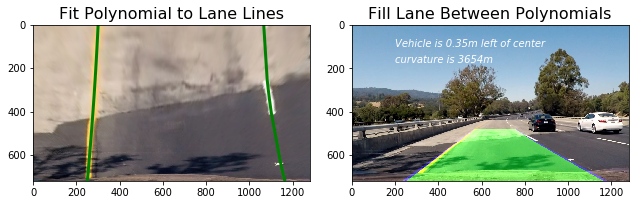

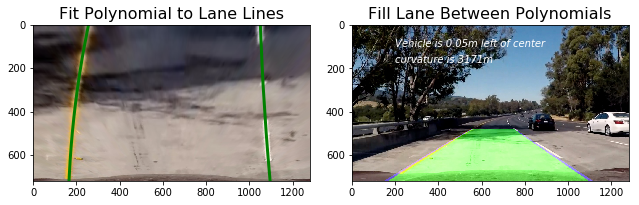

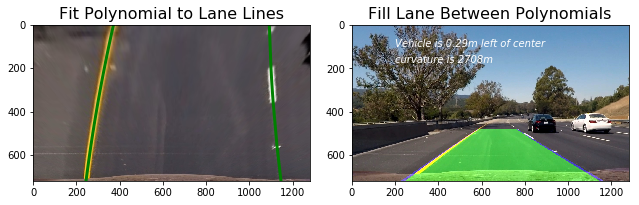

In [81]:
for image in glob.glob('test_images/test*.jpg'):
    fill_lane(image)


In [28]:
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        MARGIN=25
        xvals = []
        yvals = []
        #crappy code from lecture,.. better to do our own. Smaller margin => dont need to do recenter
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - MARGIN) < x)&(x < (xval + MARGIN))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

In [29]:
# Video Processing Pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 480],[810, 480],[1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh =(145,200)
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = (215,255)
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [30]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 98%|█████████▊| 50/51 [00:39<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [31]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [32]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_vid) 
challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████| 485/485 [06:03<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))